In [ ]:
# Need to build a semi-automated pipeline to speed up movie processing and run things overnight
# Most time consuming steps: background interpolation, CNMF fitting, Craw calculation (all parallelizable, ~45 min total per movie)
# Also somewhat time consuming - moving preprocessed files to nasquatch and then to BIDMC desktop - best to do in bulk e.g. once a day
# Rough plan would be:
    # 1. Prepare batch of movies night before - manual masking, z ranges, check for reasonable background masks, specify n_range and ?rolling sum?
        # 1.1. Manual check in napari - z range and n_range; manual check in fiji - ring mask, check threshold quality
    # 2. Overnight - run background interpolation, CNMF, Craw
        # 2.0. Room for ~15 movies' worth of outputs on colab05 HDD (main one) - save other one for raw movie archive
        # 2.1. May need to add parallel stuff here like: GPU cellpose, raw movie refitting (post-curation)
        # 2.2. Raw movie refitting is particularly important to think about - need to do smart parallelization, each one will run on just one core but for a long time (plus memmap on SSD)
    # 3. Morning - quick output quality check (probably peak SNR/bottom 10% scatterplot is enough - could print it automatically to image for each movie), move files to nasquatch/BIDMC desktop
    # 4. Rest of day - colab05 for other stuff, particularly any development/hands on work
        # 4.1. If bigwarp doesn't need colab, could just let it run unsupervised stuff all day
    # 5. Afternoon - leave enough time to prep next overnight batch, probably could be running like 15 movies overnight for CNMF-ds, raw refitting different setup (not multicore, SSD)


In [1]:
# make sure this is running in the right environment!! caiman, NOT caiman_test!
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite,imread
from skimage import measure as sm

import largestinteriorrectangle as lir
import matplotlib.patches as pac
from copy import deepcopy

from scipy import interpolate as si
from scipy import signal as sg
from skimage import measure as sm
from skimage import transform as st
from scipy.sparse import csc_matrix

from tqdm.auto import tqdm,trange

from pathlib import Path
import pickle

import cv2
import multiprocessing
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
from caiman.source_extraction.cnmf import cnmf,params
from caiman.utils.visualization import view_quilt,get_contours
from caiman.paths import caiman_datadir

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

2024-09-10 14:53:16.988092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 14:53:16.988173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 14:53:16.988210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading BokehJS ...

In [2]:
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
# remember to check space on local drive - using HDD!
# CNMF parameters for source extraction and deconvolution
# May need to adjust these a bit, e.g. gSig for the early zoomed in slice movies!
p = 0                       # order of the autoregressive system (set p=2 if there is visible rise time in data)
gnb = 0                     # number of global background components (set to 1 or 2)
low_rank_background = True
merge_thr = 1            # merging threshold, max correlation allowed
bas_nonneg = True           # enforce nonnegativity constraint on calcium traces (technically on baseline)
rf = 60                     # half-size of the patches in pixels (patch width is rf*2 + 1)
K = 30                       # number of components per patch
#gSig = np.array([10, 10, 2.5])     # expected half-width of neurons in pixels (Gaussian kernel standard deviation)
gSig = np.array([10, 10, 1.25])     # expected half-width of neurons in pixels (Gaussian kernel standard deviation) -- !!IMPORTANT - use anisotropy ~8 here!
gSiz = 2*gSig + 1           # Gaussian kernel width and hight
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data see demo_dendritic.ipynb)
rolling_sum = False         # IS THIS NECESSARY FOR DIPPING??
rolling_length = 6
ssub = 1                    # spatial subsampling during initialization 
tsub = 1                    # temporal subsampling during intialization
only_init = False
nIter = 10 #5-10 all looks fine
kernel = None
gSig = gSig/2
seed_method = 'auto'
in_memory = True
check_nan = False

# interpolation/parallelization parameters
dxy = 16
dz = 1
sigmag = [1.2,1.2,0]
n_cores = 30

In [4]:
# one more dipping
warp_ch0 = True

data_dir_l = ['/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells001/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells101/']
zmt_l = [(3,27,52,0,None),
        (3,25,52,0,None)]
n_range_l = [None for i in range(len(data_dir_l))]
snr_cutoff_l = [0.2 for i in range(len(data_dir_l))]

In [6]:
# last stray slice using ch0
warp_ch0 = False

data_dir_l = ['/mnt/nasquatch/data/2p/peter/slice/20230511_DA1PL37/slice/']
zmt_l = [(3,27,52,0,None)]
n_range_l = [np.arange(4)]
snr_cutoff_l = [0.2]

In [4]:
# unpaired slices using ch0
warp_ch0 = False

data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/wells/']
zmt_l = [(4,26,52,0,None)]
n_range_l = [None]
snr_cutoff_l = [0.2]

In [4]:
# in vivo and unpaired slices using ch1
warp_ch0 = False

data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220901_PK60PL36/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220901_PK60PL36/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230615_DG69PL32/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230615_DG69PL32/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230720_PK97PL48/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230720_PK97PL48/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230807_DG84PL52/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230807_DG84PL52/wells101/',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL3PL61/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL2PL54/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL1PL32/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL2PL60/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL2PL34/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL1PL52/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL2PL39/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230608_SL2PL45/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230608_SL1PL37/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL2PL42/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230511_DA2PL45/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA2PL55/slice/']
zmt_l = [(2,27,52,0,None),
        (3,27,52,33,75),
        (2,26,52,10,None),
        (5,25,52,0,120),
        (4,26,52,5,None),
        (3,26,52,0,165),
        (3,27,52,0,None),
        (1,26,52,0,15),
        (2,25,52,0,None),
        (9,27,52,0,None),
        (2,26,52,6,None),
        (3,25,52,0,156),
        (2,27,52,0,None),
        (3,27,52,0,None),
        (3,27,52,0,None),
        (2,26,52,0,75),
        (4,26,52,0,None),
        (5,27,52,0,None),
        (2,26,52,0,None),
        (5,27,52,0,None),
        (2,27,52,0,None),
        (2,27,52,0,None),
        (2,26,52,0,None),
        (3,27,52,0,None),
        (3,27,52,0,None),
        (2,26,52,0,None),
        (2,25,52,0,40),
        (8,27,52,0,None),
        (2,27,52,0,None),
        (2,26,52,0,None),
        (2,26,52,0,None),
        (1,17,52,0,None)]
n_range_l = [np.arange(30),
            None,
            np.arange(20),
            None,
            np.arange(20),
            None,
            np.arange(20),
            None,
            np.arange(30),
            None,
            np.arange(5),
            None,
            np.arange(10),
            None,
            np.arange(20),
            None,
            np.arange(30),
            None,
            np.arange(20),
            None,
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(5),
            np.arange(3),
            np.arange(5),
            np.arange(3),
            np.arange(3),
            np.arange(4),
            np.arange(5),
            np.arange(4)]
snr_cutoff_l = [0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.25]

In [24]:
#dipping warps - all ch0 (including rerun of 0922 wells006)
warp_ch0 = True

data_dir_l = [#'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells001/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells101/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells201/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells301/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells001/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells101/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells201/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells301/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells001/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells101/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells201/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells301/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells401/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells501/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells001/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells101/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells201/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells301/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells401/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells001/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells101/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells201/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells301/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells401/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells501/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells001/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells201/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells301/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells001/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells201/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells301/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells401/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells501/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells001/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells001/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells201/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells301/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells401/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells001/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells201/']
zmt_l = [#(3,26,31,0,None),
        #(3,27,31,0,None),
        #(4,27,31,0,None),
        #(4,27,31,0,None),
        #(2,27,31,0,None),
        #(3,27,31,0,None),
        #(3,26,31,0,None),
        #(3,27,31,0,None),
        #(2,26,31,0,None),
        #(3,27,31,0,None),
        #(3,26,31,0,None),
        #(3,27,31,0,None),
        #(2,26,31,0,None),
        #(3,27,31,0,None),
        #(2,27,31,0,None),
        #(3,25,31,0,None),
        #(5,27,31,0,None),
        #(2,27,31,0,None),
        #(2,27,31,0,None),
        #(2,26,31,0,None),
        #(3,27,31,0,None),
        #(2,27,31,0,None),
        #(2,26,31,0,None),
        #(2,26,31,0,None),
        #(3,27,31,0,None),
        #(3,27,31,0,None),
        (3,27,31,0,None),
        (2,27,31,0,None),
        (2,27,31,0,None),
        (2,26,31,0,None),
        (3,26,31,0,None),
        (3,26,31,0,None),
        (4,27,31,0,None),
        (3,26,31,0,None),
        (3,26,31,0,None),
        (3,25,31,0,None),
        (3,27,31,0,None),
        (2,27,31,0,None),
        (2,27,31,0,None),
        (3,27,31,0,None),
        (2,26,31,0,None),
        (3,27,31,0,None),
        (4,26,31,0,None),
        (2,27,31,0,None),
        (3,26,31,0,None),
        (2,27,31,0,None),
        (3,27,31,0,None),
        (2,26,52,0,None),
        (2,26,52,0,None),
        (5,25,52,0,89)]
n_range_l = [None for i in range(len(data_dir_l))]
snr_cutoff_l = [0.2 for i in range(len(data_dir_l))]

In [12]:
#slice and in vivo ch0 warp reruns!
#changed to warped_ch0 option throughout code!
warp_ch0 = True

data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells101/',
             '/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101/',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001/']
zmt_l = [(3,27,52,10,80),
        (6,26,52,20,None),
        (4,27,52,0,130),
        (4,26,52,0,None),
        (5,27,52,0,None),
        (3,27,52,0,None),
        (3,27,52,0,155),
        (2,26,52,0,None),
        (3,27,52,10,None),
        (3,27,52,0,None),
        (6,23,52,0,None),
        (3,25,52,0,None),
        (3,25,52,0,None),
        (2,26,52,0,None),
        (3,27,52,0,81)]
n_range_l = [np.arange(20),
            np.arange(10),
            np.arange(20,35),
            np.arange(30),
            None,
            np.arange(30),
            np.arange(30),
            None,
            np.arange(20),
            None,
            None,
            None,
            np.arange(5),
            None,
            None]
snr_cutoff_l = [0.25,
               0.25,
               0.25,
               0.25,
               0.2,
               0.25,
               0.25,
               0.2,
               0.25,
               0.2,
               0.2,
               0.2,
               0.25,
               0.2,
               0.2]

In [4]:
#remaining 0922 dipping, remaining slice
data_dir_l = ['/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501/',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701/',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/wells101/',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/wells101/',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/washes/',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/wells101/']
zmt_l = [(2,27,31,0,None),
        (3,27,31,0,None),
        (2,28,31,0,None),
        (2,27,31,0,None),
        (2,27,52,0,None),
        (4,27,52,0,None),
        (2,27,52,0,None),
        (8,23,52,0,71),
        (1,28,52,0,None),
        (3,27,52,0,23),
        (3,26,52,0,None),
        (5,26,52,0,None),
        (4,27,52,0,None),
        (3,27,52,0,None),
        (2,27,52,0,None),
        (2,25,52,0,None)]
n_range_l = [None,
            None,
            None,
            None,
            np.arange(5),
            None,
            np.arange(5),
            None,
            np.arange(5),
            None,
            np.arange(4),
            None,
            np.arange(5),
            np.arange(4),
            np.arange(4),
            None]
snr_cutoff_l = [0.2,
               0.2,
               0.2,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2]

In [16]:
data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/wells101/']
zmt_l = [(5,27,52,0,155),
        (5,26,52,0,120),
        (5,25,52,15,None),
        (3,27,52,10,80),
        (2,26,52,60,None),
        (6,26,52,0,159)]
n_range_l = [np.arange(30),
            np.arange(20,35),
            np.arange(20),
            np.arange(20),
            np.arange(20),
            None]
snr_cutoff_l = [0.25,
               0.25,
               0.25,
               0.25,
               0.25,
               0.2]

In [13]:
data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/220406_PK24PL10/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220406_PK24PL10/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220427_PK27PL20/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220427_PK27PL20/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221018_PS10PL24/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221018_PS10PL24/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230519_DG41PL52/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230519_DG41PL52/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230525_DG42PL39/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230525_DG42PL39/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230526_PK84PL50/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230526_PK84PL50/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230726_DG47PL54/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230726_DG47PL54/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230802_DG48PL58/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230802_DG48PL58/wells101/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230810_DG87PL55/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230810_DG87PL55/wells101/']
zmt_l = [(3,26,52,10,None),
        (3,27,52,0,None),
        (2,25,52,10,None),
        (7,28,52,0,153),
        (2,26,52,0,62),
        (7,27,52,0,174),
        (3,26,52,5,None),
        (9,27,52,0,51),
        (4,23,52,0,None),
        (10,27,52,0,18),
        (3,24,52,0,None),
        (11,27,52,0,24),
        (4,27,52,0,None),
        (3,23,52,0,45),
        (4,27,52,0,None),
        (5,26,52,0,None),
        (3,26,52,0,None),
        (4,27,52,0,None)]
n_range_l = [np.arange(20),
            None,
            np.arange(10),
            None,
            np.arange(20),
            None,
            np.arange(20),
            None,
            np.arange(20),
            None,
            np.arange(20),
            None,
            np.arange(30),
            None,
            np.arange(30),
            None,
            np.arange(30),
            None]
snr_cutoff_l = [0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2,
               0.25,
               0.2]

In [11]:
data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse/']
zmt_l = [(3,27,52,10,160),
        (5,26,52,0,120),
        (3,27,52,10,80)]
n_range_l = [np.arange(20),
            np.arange(20,35),
            np.arange(20)]
snr_cutoff_l = [0.25,
               0.25,
               0.25]

In [9]:
data_dir_l = ['/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001/']
zmt_l = [(3,26,52,0,None)]
n_range_l = [None]
snr_cutoff_l = [0.2]

In [7]:
data_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/wells101/']
zmt_l = [(3,25,31,3,None),
        (2,27,52,10,None),
        (3,21,52,0,75)]
n_range_l = [None,
            np.arange(20),
            None]
snr_cutoff_l = [0.2,
               0.25,
               0.2]

In [4]:
#updated to include SNR cutoff adjustment (20% for dipping, 25% for in vivo and slice)
data_dir_l = [#'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells001/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells201/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells401/',
             #'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601/',
             #'/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/mouse/',
             #'/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/wells101/']
             '/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/mouse/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/wells101/']
zmt_l = [#(3,27,31,0,None),
        #(2,27,31,0,None),
        #(2,27,31,0,None),
        #(2,27,31,0,None),
        #(2,26,52,60,None),
        #(6,26,52,0,159)]
        (3,26,52,5,None),
        (3,26,52,0,81)]
n_range_l = [#None,
            #None,
            #None,
            #None,
            #np.arange(20),
            #None]
            np.arange(10),
            None]
snr_cutoff_l = [#0.2,
               #0.2,
               #0.2,
               #0.2,
               #0.25,
               #0.2]
               0.25,
               0.2]

In [4]:
#previous version
data_dir_l = [#'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101/',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/slice/',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells001/',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101/']
zmt_l = [#(1,27,52,0,42),
        (3,25,52,0,None),
        (2,27,52,0,None),
        (5,23,52,0,None),
        (2,27,52,0,None),
        (3,26,52,0,None),
        (2,24,52,0,None),
        (1,27,52,0,None),
        (2,27,52,0,80),
        (3,27,52,0,None),
        (3,27,52,0,None),
        (3,24,52,0,None)]
n_range_l = [#np.arange(5),
            None,
            np.arange(5),
            None,
            np.arange(5),
            None,
            None,
            np.arange(5),
            None,
            np.arange(5),
            None,
            None]

  0%|          | 0/2 [00:00<?, ?it/s]

/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),

Interpolating background...:   0%|                                           | 0/69 [00:00<?, ?it/s]/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),
/mnt/colab/colab_shared/anaconda3/envs/caim

(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 10, 807705.3527794648)
(348480, 30, 0, 124081220.60120213)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 1205945.1349741966)
(351384, 30, 0, 213492035.6172937)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 2124749.307626862)
(351384, 30, 0, 382769943.63717085)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 10, 16493

/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 11, 3926999.0219386527)
(348480, 30, 1, 3153276.631668091)
(348480, 30, 2, 3153276.631668091)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 7210049.3348450065)
(351384, 30, 11, 2559491.1669097003)
(351384, 30, 11, 6536532.68880657)
(351384, 30, 1, 2133232.51197052)
(351384, 30, 2, 2133232.51197052)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 1, 6370893.335075378)
(351384, 30, 2, 6370893.335075378)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 11, 3872361.73236181)
(351384, 30, 1, 5247664.509567261)
(351384, 30, 2, 5247664.509567261)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 1, 2954774.2130355835)
(348480, 30, 2, 2954774.2130355835)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 1900748.0924174082)
(351384, 30, 11, 8981449.23406106)
(351384, 30, 1, 1447942.212551117)
(351384, 30, 2, 1447942.212551117)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(345600, 30, 11, 4156753.7689256878)
(351384, 30, 1, 7760937.7306518555)
(351384, 30, 2, 7760937.7306518555)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(345600, 30, 1, 3480836.64352417)
(345600, 30, 2, 3480836.64352417)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 6994317.334834322)
(351384, 30, 1, 6278216.918449402)
(351384, 30, 2, 6278216.918449402)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 19220449.013748348)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 11, 14545366.005224943)
(351384, 30, 1, 17672520.967773438)
(351384, 30, 2, 17672520.967773438)
(348480, 30, 10, 4455148.857849121)
(348480, 30, 0, 142781807.16021574)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 2871546.54784461)
(351384, 30, 11, 4762622.591253863)
(351384, 30, 1, 2518839.1381492615)
(351384, 30, 1, 12315333.365020752)
(351384, 30, 2, 2518839.1381492615)
(351384, 30, 2, 12315333.365020752)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 11, 2225063.7017672947)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 1, 4110724.6008605957)
(351384, 30, 2, 4110724.6008605957)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 11, 1271045.8380957954)
(348480, 30, 1, 1452729.163230896)
(348480, 30, 2, 1452729.163230896)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 11, 1631558.1452444936)
(348480, 30, 1, 837474.9274368286)
(348480, 30, 2, 837474.9274368286)
(348480, 30, 10, 3153276.631668091)
(348480, 30, 0, 176070487.2924976)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 1, 1137770.4912452698)
(351384, 30, 2, 1137770.4912452698)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 11, 589872.1973670032)
(348480, 30, 11, 14005287.200150825)
(348480, 30, 1, 354042.78457832336)
(348480, 30, 2, 354042.78457832336)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 1, 11592462.219055176)
(348480, 30, 2, 11592462.219055176)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(345600, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(345600, 30, 10, 3480836.64352417)
(345600, 30, 0, 130952377.11761312)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 5247664.509567261)
(351384, 30, 0, 175117381.65260452)
(348480, 30, 11, 11601644.24800819)
(351384, 30, 10, 2133232.51197052)
(351384, 30, 0, 131092624.25493476)
(348480, 30, 1, 10394685.189849854)
(348480, 30, 2, 10394685.189849854)
(351384, 30, 11, 6165453.813761124)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 7760937.7306518555)
(351384, 30, 1, 5150199.756973267)
(351384, 30, 0, 285953358.86357665)
(351384, 30, 2, 5150199.756973267)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 1447942.212551117)
(351384, 30, 0, 73231782.94318157)
(351384, 30, 11, 5401730.317346817)
(351384, 30, 10, 6370893.335075378)
(351384, 30, 0, 261413712.851479)
(351384, 30, 1, 4612354.563285828)
(351384, 30, 2, 4612354.563285828)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 10, 2954774.2130355835)
(351384, 30, 10, 2518839.1381492615)
(348480, 30, 0, 82915679.99143164)
(351384, 30, 0, 156389168.69616085)
(351384, 30, 10, 12315333.365020752)
(351384, 30, 0, 297198016.95045215)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 11, 7924281.655369439)
(351384, 30, 11, 8615228.425628934)
(351384, 30, 10, 6278216.918449402)
(351384, 30, 0, 203461011.10502765)
(351384, 30, 1, 6960096.000411987)
(351384, 30, 2, 6960096.000411987)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 1, 7087391.471817017)
(351384, 30, 2, 7087391.471817017)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 8715044.14975112)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 11, 17765170.905376952)(351384, 30, 1, 7102857.945251465)

(351384, 30, 2, 7102857.945251465)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 10, 1137770.4912452698)
(351384, 30, 0, 46582349.245832786)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 1, 15921069.265045166)
(351384, 30, 2, 15921069.265045166)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 17672520.967773438)
(351384, 30, 0, 497505053.8623843)
(348480, 30, 10, 10394685.189849854)
(348480, 30, 0, 336137989.577493)
(348480, 30, 10, 837474.9274368286)
(348480, 30, 0, 71759816.62285711)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 10, 11592462.219055176)
(348480, 30, 0, 335230637.07312983)
(351384, 30, 11, 6182989.285150776)
(348480, 30, 10, 1452729.163230896)
(348480, 30, 0, 73247976.0971233)
(351384, 30, 1, 5068888.300048828)
(351384, 30, 2, 5068888.300048828)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 21370323.093328416)
(351384, 30, 1, 19573279.37954712)
(351384, 30, 2, 19573279.37954712)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 11, 5915790.798393434)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(348480, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 4110724.6008605957)
(351384, 30, 0, 151568417.53107265)
(351384, 30, 1, 5045070.057861328)
(351384, 30, 2, 5045070.057861328)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(348480, 30, 10, 354042.78457832336)
(348480, 30, 0, 42539243.22731531)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 4612354.563285828)
(351384, 30, 0, 160179963.598066)
(348480, 30, 11, 7150144.471351415)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 7087391.471817017)
(351384, 30, 0, 209267031.82614926)
(348480, 30, 1, 6270340.867233276)
(348480, 30, 2, 6270340.867233276)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(351384, 30, 10, 5150199.756973267)
(351384, 30, 0, 227382879.19873354)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 19573279.37954712)
(351384, 30, 0, 477549556.33464265)
(351384, 30, 10, 6960096.000411987)
(351384, 30, 0, 221483328.80870366)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 7102857.945251465)
(351384, 30, 0, 206475634.67938408)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(351384, 30, 10, 15921069.265045166)
(351384, 30, 0, 447247769.4158614)
(351384, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(3513

/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 10, 6270340.867233276)
(348480, 30, 0, 256004107.96931428)
(345600, 30, 11, 4432184.968575893)
(348480, 30, 11, 4338190.541105289)
(348480, 30, 1, 3672277.1120300293)
(348480, 30, 2, 3672277.1120300293)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(345600, 30, 1, 3725278.4222869873)
(345600, 30, 2, 3725278.4222869873)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 7192655.602374389)
(351384, 30, 1, 5965894.921852112)
(351384, 30, 2, 5965894.921852112)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 11, 2205545.310393258)
(348480, 30, 1, 1513056.0776405334)
(348480, 30, 2, 1513056.0776405334)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 2840948.492883444)
(351384, 30, 1, 2396622.9523468018)
(351384, 30, 2, 2396622.9523468018)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 3013728.1761240615)
(351384, 30, 11, 1551468.5391287794)
(351384, 30, 1, 2648636.121623993)
(351384, 30, 2, 2648636.121623993)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 11, 3709747.798074471)
(351384, 30, 1, 1051095.0570831299)
(351384, 30, 2, 1051095.0570831299)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 1, 2837589.3254241943)
(348480, 30, 2, 2837589.3254241943)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 11, 5452930.613605545)
(348480, 30, 11, 13959480.109231643)
(348480, 30, 1, 4680820.522132874)
(348480, 30, 2, 4680820.522132874)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 1, 11625210.025543213)
(348480, 30, 2, 11625210.025543213)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 11, 1471246.129543556)
(348480, 30, 1, 1008443.1888504028)
(348480, 30, 2, 1008443.1888504028)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 9821879.491028938)
(351384, 30, 1, 8619149.47266388)
(351384, 30, 2, 8619149.47266388)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 8135947.10271523)
(351384, 30, 1, 7359714.816734314)
(351384, 30, 2, 7359714.816734314)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 7568888.007415898)
(348480, 30, 11, 623090.3579551764)
(351384, 30, 1, 6714945.572349548)
(351384, 30, 2, 6714945.572349548)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 1, 395762.8636608124)
(348480, 30, 2, 395762.8636608124)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 11, 12062589.885783374)
(351384, 30, 11, 5690514.659741655)
(348480, 30, 1, 10833733.80834961)
(348480, 30, 2, 10833733.80834961)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 5140442.293149329)
(351384, 30, 1, 4875986.768951416)
(351384, 30, 2, 4875986.768951416)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 1, 4423757.746559143)
(351384, 30, 2, 4423757.746559143)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 20249472.566081688)
(351384, 30, 1, 18543793.350830078)
(351384, 30, 2, 18543793.350830078)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 6170130.577418523)
(351384, 30, 1, 5211998.129646301)
(351384, 30, 2, 5211998.129646301)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 14438894.004245162)
(351384, 30, 11, 20611755.19403797)
(351384, 30, 1, 12239190.07788086)
(351384, 30, 2, 12239190.07788086)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 1, 18933953.938171387)
(351384, 30, 2, 18933953.938171387)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 9296693.297136756)
(351384, 30, 1, 7737559.86138916)
(351384, 30, 2, 7737559.86138916)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 18114018.50174413)
(351384, 30, 1, 16079631.623474121)
(351384, 30, 2, 16079631.623474121)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 9131840.834021948)
(351384, 30, 11, 5648912.978124726)
(351384, 30, 1, 7679899.443664551)
(351384, 30, 2, 7679899.443664551)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 1, 4756451.529884338)
(351384, 30, 2, 4756451.529884338)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 7740154.871379951)
(351384, 30, 1, 6858474.524856567)
(351384, 30, 2, 6858474.524856567)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(351384, 30, 11, 6887651.101190448)
(351384, 30, 1, 5896522.711929321)
(351384, 30, 2, 5896522.711929321)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(348480, 30, 11, 7435945.475520015)
(348480, 30, 1, 6545559.767601013)
(348480, 30, 2, 6545559.767601013)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


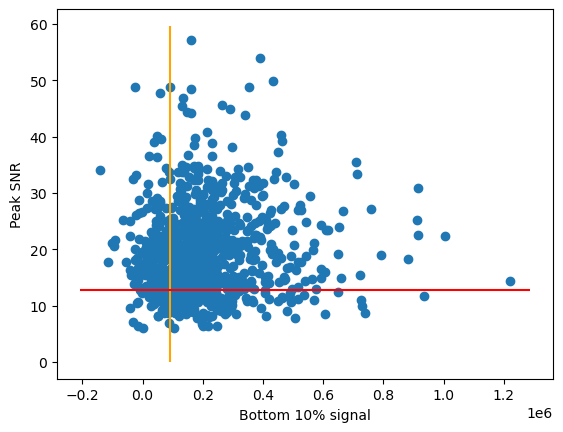

Keeping  553  components
Saved to: /mnt/hdd_cache/pkalugin/preprocessing/20230819_PL43_wells001/ch0_means_movie_nobg_cnmf.hdf5


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),

Interpolating background...:   0%|                                           | 0/63 [00:00<?, ?it/s]/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/skimage/measure/block.py:90: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),
/mnt/colab/colab_shared/anaconda3/envs/caim

(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 10, 1714812.854798615)
(319440, 30, 0, 185973319.73640147)
(319440, 30, 10, 1125236.5112874433)
(319440, 30, 0, 196832978.84646)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 2875577.2267801464)
(322102, 30, 0, 487002846.56604886)
(322102, 30, 10, 2201373.893933445)
(322102, 30, 0, 406801776.21869874)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1 s

/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(316800, 30, 11, 3543031.092236324)
(319440, 30, 11, 8723609.63371354)
(316800, 30, 1, 2754148.4449920654)
(316800, 30, 2, 2754148.4449920654)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 1, 6956106.732192993)
(319440, 30, 2, 6956106.732192993)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 11, 5099908.760069277)
(322102, 30, 1, 4465050.051071167)
(322102, 30, 2, 4465050.051071167)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 11, 7340538.6527774595)
(319440, 30, 1, 6020490.432937622)
(319440, 30, 2, 6020490.432937622)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 11, 2347603.8721254384)
(322102, 30, 1, 1855628.813194275)
(322102, 30, 2, 1855628.813194275)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 11, 2271464.5798354195)
(316800, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 1, 2010881.4828147888)
(319440, 30, 2, 2010881.4828147888)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(316800, 30, 10, 2754148.4449920654)
(316800, 30, 0, 46748466.50038909)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 11, 3902466.1467171363)
(319440, 30, 11, 6385141.2102133185)
(319440, 30, 10, 6956106.732192993)
(319440, 30, 0, 148879733.86226174)
(319440, 30, 11, 624101.3717823431)
(319440, 30, 11, 5494452.9644696545)
(319440, 30, 1, 3332768.4284362793)
(319440, 30, 2, 3332768.4284362793)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 1, 5623412.522445679)
(319440, 30, 2, 5623412.522445679)
(319440, 30, 11, 4756270.782075582)
(319440, 30, 1, 386171.0038280487)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 2, 386171.0038280487)
(319440, 30, 1, 4294544.795822144)
(319440, 30, 2, 4294544.795822144)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 1, 3901569.6499557495)
(319440, 30, 2, 3901569.6499557495)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 11, 25980643.46080801)
(322102, 30, 11, 4746618.043593977)
(322102, 30, 1, 23463790.550201416)
(322102, 30, 2, 23463790.550201416)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 1, 3834565.3644866943)
(322102, 30, 2, 3834565.3644866943)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 11, 2854224.0739734797)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 1, 2199471.5115890503)
(322102, 30, 2, 2199471.5115890503)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 10, 4465050.051071167)
(322102, 30, 0, 180386019.0043225)
(319440, 30, 10, 6020490.432937622)
(322102, 30, 10, 9297633.940948486)
(319440, 30, 0, 128942346.79566047)
(322102, 30, 0, 222648405.27524522)
(322102, 30, 11, 11368846.531518683)
(322102, 30, 11, 18057984.80550454)
(322102, 30, 11, 3704214.3631758867)
(322102, 30, 1, 16049606.218597412)
(322102, 30, 2, 16049606.218597412)
(322102, 30, 1, 10316759.371932983)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 2, 10316759.371932983)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 1, 3083693.4244918823)
(322102, 30, 2, 3083693.4244918823)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 11, 8853133.377658878)
(322102, 30, 1, 7666713.490783691)
(322102, 30, 2, 7666713.490783691)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 11, 10306302.932648297)
(319440, 30, 10, 2010881.4828147888)
(319440, 30, 0, 86118056.83802144)
(322102, 30, 1, 9270405.40284729)
(322102, 30, 2, 9270405.40284729)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 10, 386171.0038280487)
(319440, 30, 11, 8394721.65078966)
(319440, 30, 0, 34627116.470892504)
(322102, 30, 11, 13056307.491706666)
(319440, 30, 1, 6758477.384933472)
(319440, 30, 2, 6758477.384933472)
(322102, 30, 1, 11012938.421524048)
(322102, 30, 2, 11012938.421524048)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 10, 4294544.795822144)
(319440, 30, 0, 107057703.36782554)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 11, 9328781.369934628)
(322102, 30, 11, 2392953.7789395563)
(322102, 30, 10, 3834565.3644866943)
(322102, 30, 0, 115359765.15084663)
(322102, 30, 1, 7417257.046401978)
(322102, 30, 2, 7417257.046401978)
(322102, 30, 1, 1955428.1853256226)
(322102, 30, 2, 1955428.1853256226)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 11, 8014042.333539581)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 10, 5623412.522445679)
(319440, 30, 0, 119574280.71116078)
(322102, 30, 1, 6614579.88142395)
(322102, 30, 2, 6614579.88142395)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 10, 1855628.813194275)
(322102, 30, 0, 151569729.8960819)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 10, 3901569.6499557495)
(319440, 30, 0, 86315813.79992163)
(322102, 30, 10, 16049606.218597412)
(322102, 30, 0, 280798098.7366825)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 10, 3332768.4284362793)
(319440, 30, 0, 149223262.12933794)
(322102, 30, 11, 10636445.837948374)
(322102, 30, 11, 10926665.43986293)
(322102, 30, 1, 9586565.954986572)
(322102, 30, 2, 9586565.954986572)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 1, 9065494.479598999)
(322102, 30, 2, 9065494.479598999)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 11012938.421524048)
(322102, 30, 0, 258742674.79670706)
(322102, 30, 11, 8699080.517135568)
(322102, 30, 10, 10316759.371932983)
(322102, 30, 0, 265242929.4795909)
(322102, 30, 11, 12140769.912670814)
(322102, 30, 1, 7615213.749237061)
(322102, 30, 2, 7615213.749237061)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 2199471.5115890503)
(322102, 30, 0, 98127403.11465682)
(322102, 30, 10, 9270405.40284729)
(322102, 30, 0, 226807312.48860267)
(322102, 30, 1, 10148028.018081665)
(322102, 30, 2, 10148028.018081665)
(322102, 30, 10, 23463790.550201416)
(322102, 30, 0, 446433245.5755662)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 11, 11375203.5116769)
(322102, 30, 1, 9549672.649093628)
(322102, 30, 2, 9549672.649093628)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 7666713.490783691)
(322102, 30, 0, 236671013.2017904)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(319440, 30, 10, 6758477.384933472)
(319440, 30, 0, 144518490.29144526)
(322102, 30, 10, 1955428.1853256226)
(322102, 30, 0, 73720591.41820133)
(322102, 30, 10, 3083693.4244918823)
(322102, 30, 0, 104875914.13010289)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 6614579.88142395)
(322102, 30, 0, 133297811.42403206)
(32210

/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 10148028.018081665)
(322102, 30, 0, 228401008.19514018)
(322102, 30, 10, 7615213.749237061)
(322102, 30, 0, 214775105.67565453)
(322102, 30, 9, <1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>)
(322102, 30, 10, 9549672.649093628)
(322102, 30, 0, 252813944.32591677)
(316800, 30, 11, 3513768.857887791)
(316800, 30, 1, 2758722.3643341064)
(316800, 30, 2, 2758722.3643341064)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 2539752.362644344)
(319440, 30, 1, 2257532.8407058716)
(319440, 30, 2, 2257532.8407058716)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 6383200.698475537)
(319440, 30, 1, 5016825.653869629)
(319440, 30, 2, 5016825.653869629)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 9827632.61757198)
(322102, 30, 1, 8735460.265670776)
(322102, 30, 2, 8735460.265670776)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 5487327.988533346)
(322102, 30, 1, 4877592.524291992)
(322102, 30, 2, 4877592.524291992)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 5206685.135173058)
(319440, 30, 11, 608502.4882586405)
(319440, 30, 1, 4162067.9084625244)
(319440, 30, 2, 4162067.9084625244)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 1, 398064.14622306824)
(319440, 30, 2, 398064.14622306824)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 5243306.628248324)
(319440, 30, 1, 4342978.422668457)
(319440, 30, 2, 4342978.422668457)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 6170532.233880568)
(319440, 30, 1, 5406607.890426636)
(319440, 30, 2, 5406607.890426636)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 5036383.160424459)
(322102, 30, 1, 4077645.3343811035)
(322102, 30, 2, 4077645.3343811035)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 3198078.4325398253)
(322102, 30, 11, 2508479.1119433306)
(322102, 30, 1, 2512829.213104248)
(322102, 30, 2, 2512829.213104248)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 1, 1960079.2382507324)
(322102, 30, 2, 1960079.2382507324)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 7491547.9226611415)
(319440, 30, 1, 6185898.211212158)
(319440, 30, 2, 6185898.211212158)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(319440, 30, 11, 4795279.709646317)
(319440, 30, 1, 4107498.490776062)
(319440, 30, 2, 4107498.490776062)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 18594380.783511367)
(322102, 30, 1, 16659195.482971191)
(322102, 30, 2, 16659195.482971191)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 2724297.9745964827)
(322102, 30, 1, 2342521.6970329285)
(322102, 30, 2, 2342521.6970329285)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 11497975.808272317)
(322102, 30, 11, 11248763.422290087)
(322102, 30, 11, 23265370.934589304)
(322102, 30, 11, 12158566.414092895)
(322102, 30, 1, 10397008.34689331)
(322102, 30, 2, 10397008.34689331)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 1, 9508717.70187378)
(322102, 30, 2, 9508717.70187378)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 1, 20851912.391326904)
(322102, 30, 2, 20851912.391326904)(322102, 30, 1, 10309432.770126343)

(322102, 30, 2, 10309432.770126343)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 3493632.601894295)
(322102, 30, 1, 2865994.083595276)
(322102, 30, 2, 2865994.083595276)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 8480192.413061175)
(322102, 30, 1, 6997804.853866577)
(322102, 30, 2, 6997804.853866577)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 10011668.683117017)
(322102, 30, 1, 8906955.544876099)
(322102, 30, 2, 8906955.544876099)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 9581503.06651292)
(322102, 30, 1, 8505545.825538635)
(322102, 30, 2, 8505545.825538635)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 8623998.094600022)
(322102, 30, 1, 7459314.643508911)
(322102, 30, 2, 7459314.643508911)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 8720004.323859476)
(322102, 30, 1, 7262643.484893799)
(322102, 30, 2, 7262643.484893799)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 11334477.821656935)
(322102, 30, 11, 12178344.154227406)
(322102, 30, 1, 9523143.250305176)
(322102, 30, 2, 9523143.250305176)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 1, 10499280.45539856)
(322102, 30, 2, 10499280.45539856)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


(322102, 30, 11, 9109740.718921173)
(322102, 30, 1, 8011448.257728577)
(322102, 30, 2, 8011448.257728577)


/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 63, using nperseg = 63
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
/mnt/colab/colab_shared/anaconda3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_dia.py:277: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


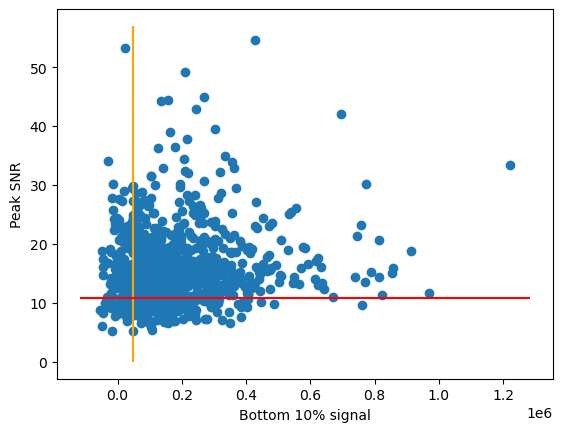

Keeping  604  components
Saved to: /mnt/hdd_cache/pkalugin/preprocessing/20230819_PL43_wells101/ch0_means_movie_nobg_cnmf.hdf5


In [6]:
for m in trange(0,len(data_dir_l)):
    data_dir = data_dir_l[m]
    z1 = zmt_l[m][0]
    z2 = zmt_l[m][1]
    mov_means = zmt_l[m][2]
    t1 = zmt_l[m][3]
    t2 = zmt_l[m][4]
    n_range = n_range_l[m]
    snr_cutoff = snr_cutoff_l[m]

    if warp_ch0:
        fnamex = os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_means)+'_mean_warped_ch0/means_movie.npy')
    else:
        fnamex = os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_means)+'_mean_warped_/means_movie.npy')
    Yx = np.load(fnamex,mmap_mode='r+')
    Yx = Yx.transpose([0,2,3,1])
    Yx = Yx[t1:t2,:,:,z1:z2]

    Yz = np.min(Yx,axis=0)
    Yz = np.array(Yz!=0,order='C')
    Yd = np.min(Yz,axis=2)
    vgrid2 = lir.lir(np.array(Yd,order='C'))
    vgrid2[2] = vgrid2[0]+vgrid2[2]
    vgrid2[3] = vgrid2[1]+vgrid2[3]
    Yxx = Yx[:,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],:]
    dims = Yxx.shape[1:]

    if warp_ch0:
        pname = os.path.join(data_dir, 'segtrack/segs/ch0/'+str(mov_means)+'_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/prob_movie_tmax_blur.tiff')
    else:
        pname = os.path.join(data_dir, 'segtrack/segs/ch0/'+str(mov_means)+'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/prob_movie_tmax_blur.tiff')
    pmap = imread(pname) # this is mask based on thresholded probmap (cell vs not cell) - for some movies may need to include additional defect mask!
    pmap = pmap.transpose([1,2,0])
    pmap = pmap[vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],z1:z2]
    pmask = pmap<0 # this is the "not cell" mask
    pmask3 = pmap>0 # this is the "cell" mask

    if warp_ch0:
        bname = os.path.join(data_dir, 'segtrack/segs/ch0/'+str(mov_means)+'_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/prob_movie_tmax_blur_circle.tif')
    else:
        bname = os.path.join(data_dir, 'segtrack/segs/ch0/'+str(mov_means)+'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/prob_movie_tmax_blur_circle.tif')
    bmap = imread(bname) # this is the "GRIN" mask removing out of lens background
    bmap = bmap[0,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2]]
    bmask = bmap>0

    pmask2 = pmask.transpose([2,0,1]) # transpose for correct broadcasting - axis they don't share should be first (in this case z)
    bgmask = np.multiply(pmask2,bmask) # this is the in-GRIN background mask
    bgmask = bgmask.transpose([1,2,0])
    bgmask = bgmask.astype('bool')

    Yxy = np.multiply(Yxx,bgmask) # this is the masked background signal (to be interpolated)

    alls = np.ones(Yxx.shape[1:])
    bmaskz = np.multiply(alls.transpose([2,0,1]),bmask)
    bmaskz = bmaskz.astype('bool')
    bmaskz = bmaskz.transpose([1,2,0]) # this is the "GRIN" mask cylinder in z

    Yxxb = np.multiply(Yxx,bmaskz) # this is the original signal movie only in GRIN

    # here the background interpolation starts - copy the bg-masked movie and set non-bg to NaN, then interpolate into the holes
    Yxy2 = np.copy(Yxy)
    Yxy2[Yxy2==0] = 'nan'

    # parallelized background interpolation - for 169 frame movie across 35 cores, it takes 9:31 min
    y = np.linspace(0,Yxy2.shape[1]-1,Yxy2.shape[1])
    x = np.linspace(0,Yxy2.shape[2]-1,Yxy2.shape[2])
    z = np.linspace(0,Yxy2.shape[3]-1,Yxy2.shape[3])
    pos = np.meshgrid(y,x,z)
    posarr = np.asarray(pos)
    posarr = posarr.transpose([2,1,3,0])
    posarrf = posarr.reshape([-1,3])
    Yxy2tdx = sm.block_reduce(Yxy2[0,:,:,:],block_size=(dxy,dxy,dz),func=np.nanmedian,cval=np.nan)
    yd = np.arange((dxy-1)/2,Yxy2tdx.shape[0]*dxy,dxy)
    xd = np.arange((dxy-1)/2,Yxy2tdx.shape[1]*dxy,dxy)
    zd = np.arange((dz-1)/2,Yxy2tdx.shape[2]*dz,dz)
    posd = np.meshgrid(yd,xd,zd)
    posdarr = np.asarray(posd)
    posdarr = posdarr.transpose([2,1,3,0]) #could fix some of this by switching to 'ij' instead of 'xy' in meshgrid
    posdarrf = posdarr.reshape([-1,3])
    
    def process(t):
        Yxy2t = Yxy2[t,:,:,:] - Yxy2[0,:,:,:]
        Yxy2td = sm.block_reduce(Yxy2t,block_size=(dxy,dxy,dz),func=np.nanmedian,cval=np.nan)
        Yxy2tdf = Yxy2td.flatten()
        posdarrt = np.copy(posdarr)
        posdarrtf = posdarrt.reshape(Yxy2tdf.shape + (-1,))
        Yxy2tdfn = Yxy2tdf[~np.isnan(Yxy2tdf)]
        posdarrtfn = posdarrtf[~np.isnan(Yxy2tdf),:]
        intrbfd = si.RBFInterpolator(posdarrtfn,Yxy2tdfn,degree=1,smoothing=100)
        Yxy2tdi1 = intrbfd(posdarrf)
        Yxy2tdi1 = Yxy2tdi1.reshape(Yxy2td.shape)
        Yxy2tdi = gaussian_filter(Yxy2tdi1,sigma=sigmag,mode='nearest')
        Yxy2tdiup = si.interpn((yd,xd,zd),Yxy2tdi,posarrf,bounds_error=False,fill_value=None)
        Yxy2tdiup = Yxy2tdiup.reshape(Yxy2t.shape)
        return Yxy2tdiup
        
    with tqdm_joblib(tqdm(desc="Interpolating background...", total=len(range(Yxy2.shape[0])))) as progress_bar:
        results = Parallel(n_jobs=n_cores)(delayed(process)(t) for t in range(Yxy2.shape[0]))
    
    Yxy2bg = np.asarray(results)
    get_reusable_executor().shutdown(wait=True)

    Yxxbnobg = Yxxb - np.multiply(Yxy2bg,bmaskz)

    # keep an eye on directories - do everything locally (much faster) then move to nasquatch at the very end!
    try:
        os.mkdir(os.path.join('/mnt/hdd_cache/pkalugin', 'preprocessing', os.path.split(os.path.dirname(os.path.dirname(data_dir)))[1] + '_' + os.path.split(os.path.dirname(data_dir))[1]))
    except:
        pass
    base_dir = os.path.join('/mnt/hdd_cache/pkalugin', 'preprocessing', os.path.split(os.path.dirname(os.path.dirname(data_dir)))[1] + '_' + os.path.split(os.path.dirname(data_dir))[1])
    fnamebg = os.path.join(base_dir, 'ch0_means_movie_bg.tif')
    imwrite(fnamebg,np.multiply(Yxy2bg,bmaskz))
    fnames = os.path.join(base_dir, 'ch0_means_movie_nobg.tif')
    imwrite(fnames,Yxxbnobg)

    Y = cm.load(fnames)
    Cn = cm.local_correlations(Y, swap_dim=False)

    #%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
    n_processes = n_cores
    if 'dview' in locals():
        cm.stop_server(dview=dview)
    c, dview, n_processes = cm.cluster.setup_cluster(
        backend='multiprocessing', n_processes=n_processes, single_thread=False)
    #n_processes

    # on colab05 saving to nasquatch, this takes >10 min - too long, not worth it!
    # instead, do this all locally, then move to nasquatch at the very end! takes just 40 sec locally!
    ## NO MOTION CORRECTION
    # without motion correction - use correct file!!
    os.chdir(base_dir)
    fnamesmm = np.memmap('nomc_' + os.path.split(fnames)[1][:-4] + '.mmap', dtype=Y.dtype, mode='w+', shape=Y.shape, order='F')
    fnamesmm[:] = Y[:]
    
    mc_memmapped_fname = cm.save_memmap(list(fnamesmm), base_name='memmap_', is_3D=True,
                                         order='C', border_to_0=0, dview=None)
    
    Yr, dims, T = cm.load_memmap(mc_memmapped_fname)
    images = np.reshape(Yr.T, [T] + list(dims), order='F') 

    stride_cnmf = int(np.min([40,np.floor(150-np.min([Cn.shape[0],Cn.shape[1]])/4)]))             # amount of overlap between the patches in pixels (overlap is stride_cnmf+1) 

    parameter_dict = {'fnames': fnames,
                      'p': p,
                      'nb': gnb,
                      'rf': rf,
                      'K': K, 
                      'gSig': gSig,
                      'gSiz': gSiz,
                      'stride': stride_cnmf,
                      'method_init': method_init,
                      'rolling_sum': rolling_sum, #important
                      'rolling_length': rolling_length,
                      'only_init': only_init, #also keep an eye on this
                      'ssub': ssub,
                      'tsub': tsub,
                      'merge_thr': merge_thr, 
                      'bas_nonneg': bas_nonneg,
                      'kernel': kernel,
                      'nIter': nIter
                     }
    
    parameters = params.CNMFParams(params_dict=parameter_dict) # CNMFParams is the parameters class

    cnmf_model = cnmf.CNMF(n_processes, 
                           params=parameters, 
                           dview=dview)

    # will throw error in wrong environment (needs modified caiman for nb=0!)
    # takes 15 min for locally stored movie 169 frames, 30 patches, 30 cells per patch
    cnmf_fit = cnmf_model.fit(images)

    # STOP CLUSTER
    cm.stop_server(dview=dview)

    ## SNR calculation and cutoff determination
    CY = cnmf_fit.estimates.C + cnmf_fit.estimates.YrA
    def sav_calc(sraw):
        return sg.savgol_filter(sraw,3,1)
    savres = Parallel(n_jobs=n_cores)(delayed(sav_calc)(raw) for raw in list(CY))
    CYsav = np.asarray(savres)
    get_reusable_executor().shutdown(wait=True)
    
    CYsavsort = np.sort(CYsav,axis=1)
    CYsavt10 = np.mean(CYsavsort[:,int(CYsavsort.shape[1]-np.ceil(CYsavsort.shape[1]/10)):],axis=1) # top 10% mean
    CYsavb10 = np.mean(CYsavsort[:,:int(np.ceil(CYsavsort.shape[1]/10))],axis=1) # bottom 10% mean
    if n_range is None:
        sig = CYsavt10 - CYsavb10
    else:
        sig = CYsavt10 - np.mean(CYsav[:,n_range],axis=1) # baseline mean
    
    noisestd = np.std(CY - CYsav,axis=1) # noise calculated across whole movie
    SNR = sig/noisestd
    SNRsort = np.sort(SNR)
    SNRmin = SNRsort[int(np.floor(snr_cutoff*SNRsort.shape[0]))]

    ## Nonnegative cutoff determination
    dist = CYsavb10[CYsavb10<0]
    dist = np.concatenate((dist,-dist))
    Sigmin = np.std(dist)*1.96

    fig,ax = plt.subplots()
    ax.scatter(CYsavb10,SNR)
    plt.xlabel("Bottom 10% signal")
    plt.ylabel("Peak SNR")
    plt.vlines(Sigmin,0,plt.gca().get_ylim()[1],color='orange')
    plt.hlines(SNRmin,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],color='r')
    plt.show()
    keepargs = np.intersect1d(np.where(SNR>SNRmin),np.where(CYsavb10>Sigmin))
    print("Keeping ", str(keepargs.shape[0]) ," components")

    # ~5:18 min total for 169 fr mouse movie
    Cthr = 0.9 # contour energy threshold
    d = cnmf_model.estimates.A.shape[0]
    dims = cnmf_model.estimates.dims
    axis = 2
    order = list(range(4))
    order.insert(0, order.pop(axis))
    index_permut = np.reshape(np.arange(d), dims, order='F').transpose(
            order[:-1]).reshape(d, order='F')
    A = csc_matrix(cnmf_model.estimates.A)[index_permut, :]
    dims = tuple(np.array(dims)[order[:3]])
    d1, d2, d3 = dims
    nr, T = cnmf_model.estimates.C.shape
    image_cells = np.array(A.mean(axis=1)).reshape(dims, order='F')
    coors = get_contours(A, dims, thr=Cthr)
    with open(os.path.join(base_dir, 'ch0_means_movie_nobg_coors.pickle'), 'wb') as f:
        pickle.dump(coors, f)
    
    # 3:34 min with multiprocessing over 35 cores!
    #n_cores = 35
    spcomps = np.reshape(cnmf_fit.estimates.A.toarray(),cnmf_fit.estimates.dims + (-1,),order='F')
    spcomps = spcomps.transpose([3,2,0,1])
    images2 = images.transpose([0,3,1,2])
    C = cnmf_fit.estimates.C # temporal loadings
    def process2(nr):
        return np.sum((images2*spcomps[nr,...]).reshape([images2.shape[0],-1]),axis=1).T/np.sum(spcomps[nr,...])
    results2 = Parallel(n_jobs=n_cores)(delayed(process2)(nr) for nr in range(spcomps.shape[0]))
    Craw = np.asarray(results2)
    get_reusable_executor().shutdown(wait=True)

    cnmf_fit.estimates.Cn = np.nan_to_num(Cn)
    cnmf_fit.estimates.n_range = n_range
    cnmf_fit.estimates.CYsav = CYsav
    cnmf_fit.estimates.SNR_comp = SNR
    cnmf_fit.estimates.SNRmin = SNRmin
    cnmf_fit.estimates.Sigmin = Sigmin
    cnmf_fit.estimates.keepargs = keepargs
    cnmf_fit.estimates.Craw = Craw

    # save data
    #print("Saving CNMF model...")
    save_path = os.path.join(base_dir, 'ch0_means_movie_nobg_cnmf.hdf5')
    cnmf_fit.save(save_path)
    
    print("Saved to:",save_path)

    # copy from local to nasquatch
    _orig_copystat = shutil.copystat
    shutil.copystat = lambda *a, **k: None
    shutil.copytree(base_dir,os.path.join(data_dir, 'preprocessing', os.path.split(os.path.dirname(os.path.dirname(data_dir)))[1] + '_' + os.path.split(os.path.dirname(data_dir))[1]))
    shutil.copystat = _orig_copystat